# Imports

In [32]:
import pandas as pd
import numpy as np
from scipy import stats
from mlxtend.preprocessing import minmax_scaling
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import charset_normalizer
import fuzzywuzzy
from fuzzywuzzy import process

np.random.seed(0)

C:\Users\jgibb\.pyenv\pyenv-win\versions\3.12.5\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Missing data

In [ ]:
sf_permits = pd.read_csv("data/kaggle/courses/Building_Permits.csv")

n_missing = sf_permits.isnull().sum()
n_total = np.prod(sf_permits.shape)
percent_missing = (n_missing.sum()/n_total) * 100

rows_with_na_dropped = sf_permits.dropna(axis=0)
columns_with_na_dropped = sf_permits.dropna(axis=1)

fill_with_0s = sf_permits.fillna(0)
fill_with_next = sf_permits.bfill().fillna(0)

# Scaling and normalisation

Original data		Minimum value: 0.01	Maximum value: 166361390.71
nNormalized data	Minimum value: -4.37	Maximum value: 23.61


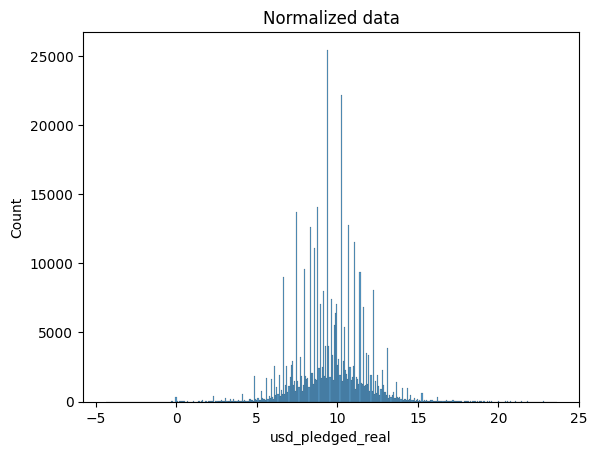

In [24]:
kickstarters_2017 = pd.read_csv("data/kaggle/courses/ks-projects-201801.csv")

scaled_goals = minmax_scaling(pd.DataFrame(kickstarters_2017['usd_goal_real']), columns=['usd_goal_real'])

# Box-Cox only takes positive values
index_of_positive_pledges = kickstarters_2017['usd_goal_real'] > 0
positive_pledges = kickstarters_2017['usd_goal_real'].loc[index_of_positive_pledges]
normalized_pledges = pd.Series(stats.boxcox(positive_pledges)[0], name='usd_pledged_real', index=positive_pledges.index)

print(f'Original data\t\tMinimum value: {float(positive_pledges.min()):.2f}\tMaximum value: {float(positive_pledges.max()):.2f}')
print(f'nNormalized data\tMinimum value: {float(normalized_pledges.min()):.2f}\tMaximum value: {float(normalized_pledges.max()):.2f}')

ax = sns.histplot(normalized_pledges)
ax.set_title("Normalized data")
plt.show()

# Parsing dates

Date
10    23409
24        3
Name: count, dtype: int64
Indices with corrupted data: [ 3378  7512 20650]
3378     1975-02-23T02:58:41.000Z
7512     1985-04-28T02:53:41.530Z
20650    2011-03-13T02:23:34.520Z
Name: Date, dtype: object


C:\Users\jgibb\AppData\Local\Temp\ipykernel_10172\2097733321.py:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(day_of_month_earthquakes, kde=False, bins=31)


<Axes: xlabel='date_parsed'>

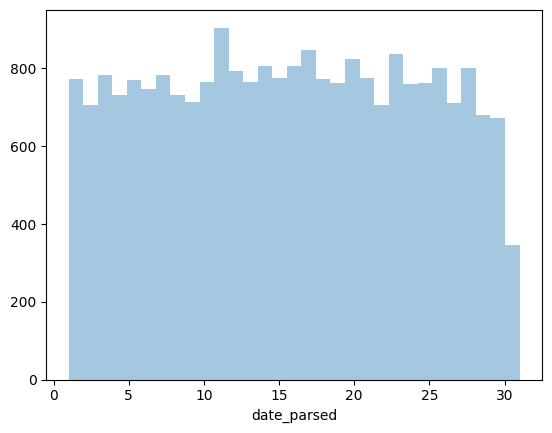

In [28]:
earthquakes = pd.read_csv("data/kaggle/courses/earthquake-database.csv")

earthquakes['Date'].dtype

date_lengths = earthquakes.Date.str.len()
print(date_lengths.value_counts())
indices = np.where([date_lengths == 24])[1]
print('Indices with corrupted data:', indices)
print(earthquakes.loc[indices]['Date'])

earthquakes.loc[3378, "Date"] = "02/23/1975"
earthquakes.loc[7512, "Date"] = "04/28/1985"
earthquakes.loc[20650, "Date"] = "03/13/2011"
earthquakes['date_parsed'] = pd.to_datetime(earthquakes['Date'], format="%m/%d/%Y")
# earthquakes['date_parsed'] = pd.to_datetime(earthquakes['Date'], infer_datetime_format=True)

day_of_month_earthquakes = earthquakes['date_parsed'].dt.day
day_of_month_earthquakes = day_of_month_earthquakes.dropna()
sns.distplot(day_of_month_earthquakes, kde=False, bins=31)

# Character encodings

In [ ]:
sample_entry = b'\xa7A\xa6n'
sample_decoded = sample_entry.decode('big5-tw', errors='ignore')
new_entry = sample_decoded.encode()

with open("../input/fatal-police-shootings-in-the-us/PoliceKillingsUS.csv", 'rb') as rawdata:
    result = charset_normalizer.detect(rawdata.read(100000))
print(result)

police_killings = pd.read_csv("../input/fatal-police-shootings-in-the-us/PoliceKillingsUS.csv", encoding=result['encoding'])

# Inconsistent data entry and fuzzing

In [35]:
professors = pd.read_csv("data/kaggle/courses/pakistan_intellectual_capital.csv")

countries = professors['Country'].unique()
countries.sort()
countries

professors['Graduated from'] = professors['Graduated from'].str.strip()

def replace_matches_in_column(df, column, string_to_match, min_ratio = 47):
    strings = df[column].unique()
    matches = fuzzywuzzy.process.extract(string_to_match, strings, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]
    rows_with_matches = df[column].isin(close_matches)
    df.loc[rows_with_matches, column] = string_to_match
    print("All done!")

matches = fuzzywuzzy.process.extract("usa", countries, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
replace_matches_in_column(df=professors, column='Country', string_to_match="usa", min_ratio=70)

All done!
